## Setup

In [1]:
import pandas as pd
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import preprocess_data
from src.utils import feature_engg

import geopandas as gpd
from shapely.geometry import Point, Polygon

from dotenv import load_dotenv
import os

load_dotenv()
ROOT_DIR = os.environ.get("ROOT_DIR")
os.chdir(ROOT_DIR)


## Data Ingestion

In [2]:
df = pd.read_csv(r"data\raw\Train.csv")

## Data Preprocessing

### Analysing the data

Checking the data type and the null values in our data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Checking unique values of balcony, total square feet, and size, for understanding what needs to be cleaned and analyse how to clean it.

In [6]:
columns = ['area_type','balcony', 'total_sqft', 'size']

for col in columns:
    unique_values = df[col].unique()
    print(f"Unique values for column '{col}': {unique_values}")

Unique values for column 'area_type': ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
Unique values for column 'balcony': [ 1.  3. nan  2.  0.]
Unique values for column 'total_sqft': ['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']
Unique values for column 'size': ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' nan '9 Bedroom' '27 BHK'
 '10 Bedroom' '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom'
 '14 BHK' '8 BHK' '12 Bedroom' '13 BHK' '18 Bedroom']


## Checking frequency of variables which have null values

This will show us which variables/variable ranges are more prominent in the market

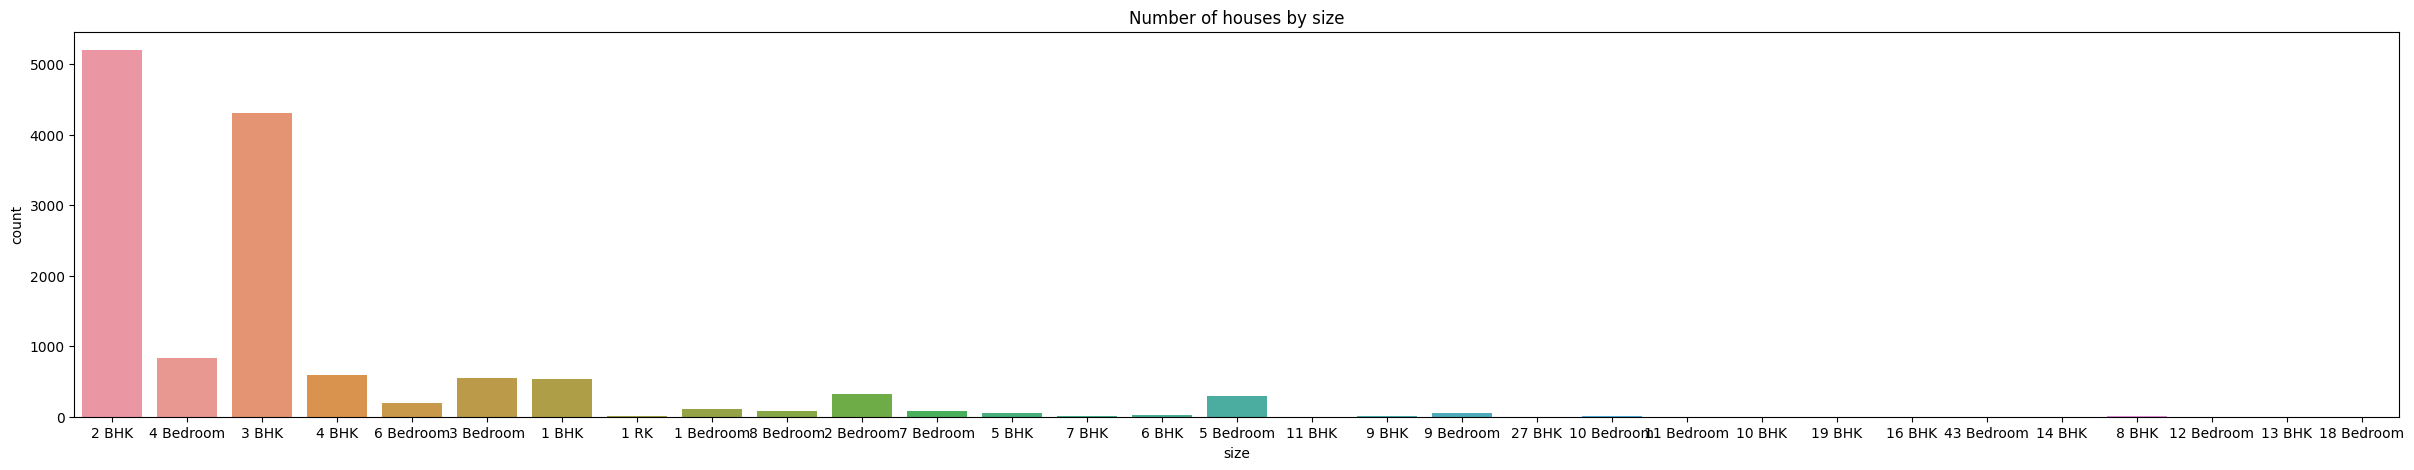

In [7]:
def size_plot(df,col):
    plt.figure(figsize=(30,5))
    sns.countplot(df, x=col)
    plt.title('Number of houses by size')

size_plot(df, 'size')

We see from the graph that most houses are 2BHK and 3BHK, but there are houses with 2/3 bed and bath mentioned as bedroom only so we will have to clean the data based on that and check again.

Spatial analysis using geopandas and geoplots to check location concentration 

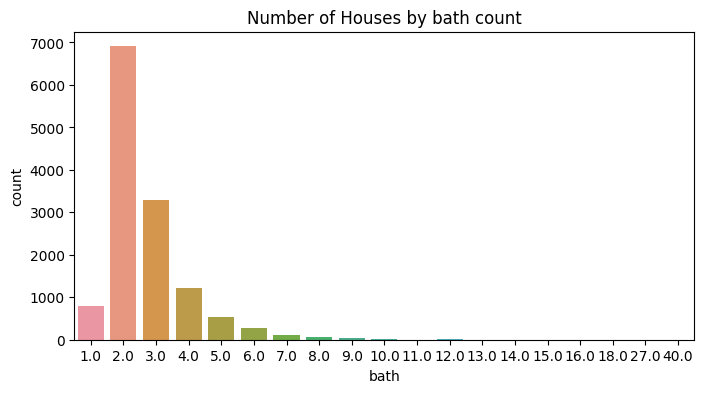

In [8]:
def bath_plot():
    plt.figure(figsize=(8,4))
    sns.countplot(x=df.bath)
    plt.title('Number of Houses by bath count')

bath_plot()

Bath count of 2 and 3 is most popular, with a few houses with 40 bathrooms!

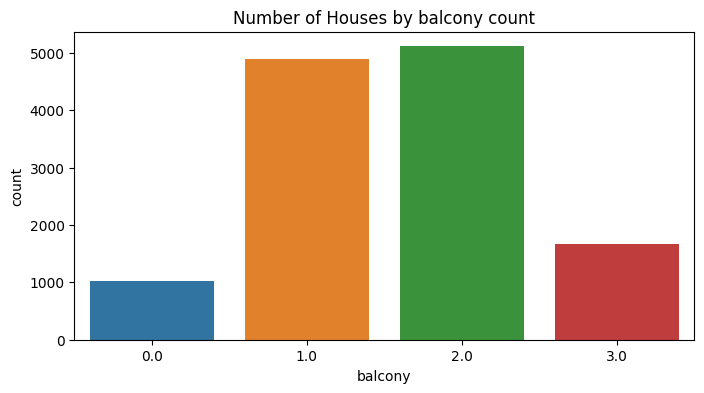

In [9]:
def balcony_plot():
    plt.figure(figsize=(8,4))
    sns.countplot(x=df.balcony)
    plt.title('Number of Houses by balcony count')

balcony_plot()

## Creating plots for other variables to check for other value range and count 

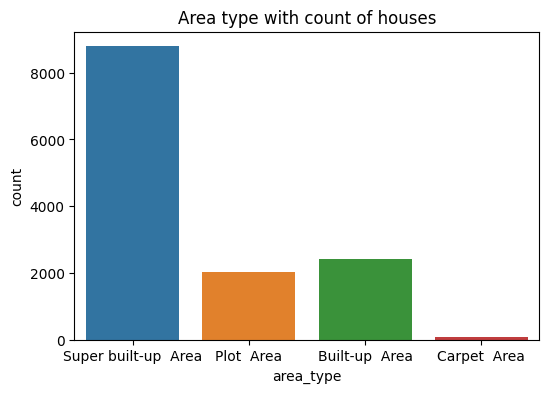

In [10]:
def areatype_plot():
    plt.figure(figsize=(6,4))
    sns.countplot(x=df.area_type)
    plt.title('Area type with count of houses')

areatype_plot()

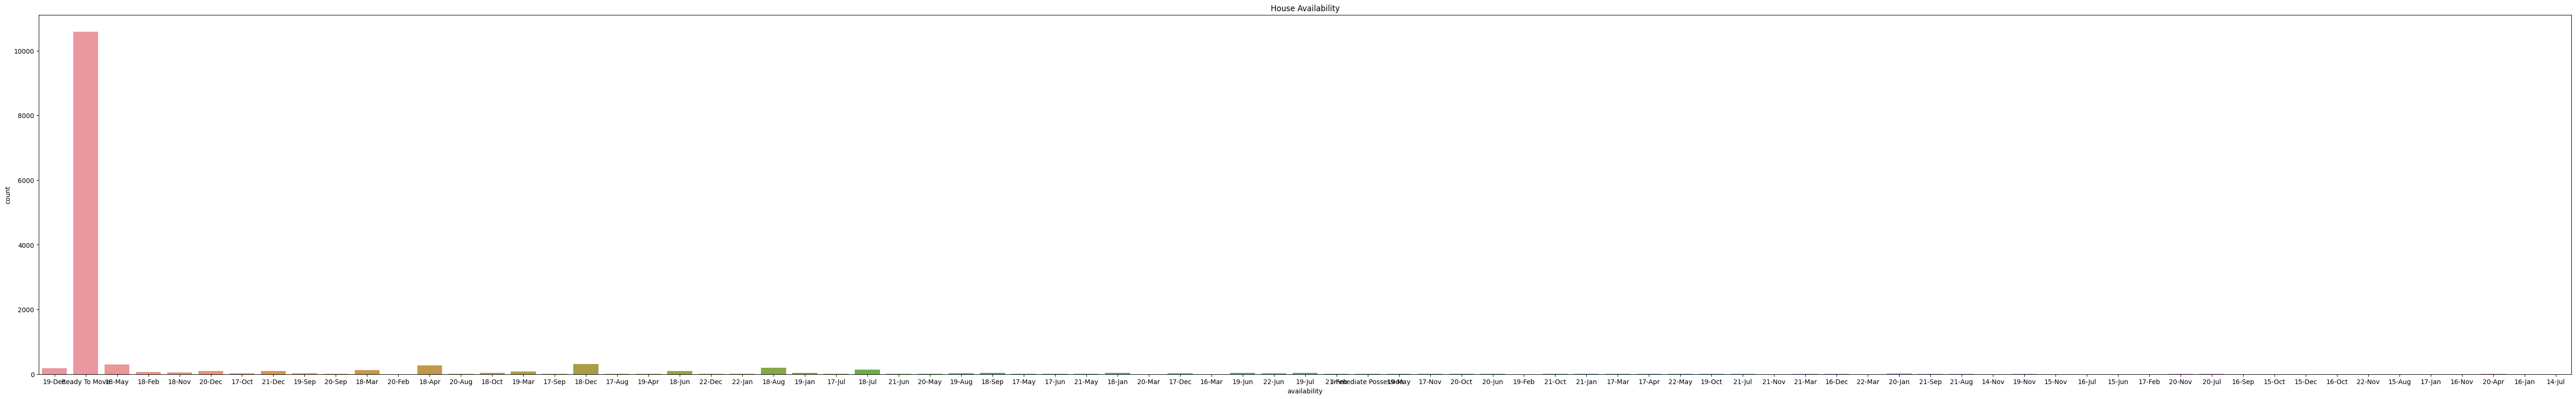

In [11]:
def availability_plot():
    plt.figure(figsize=(70,10))
    sns.countplot(x=df.availability)
    plt.title('House Availability')

availability_plot()

From this graph we see that max houses are offered as ready to move in, and the data is skewed to ready to move in houses.

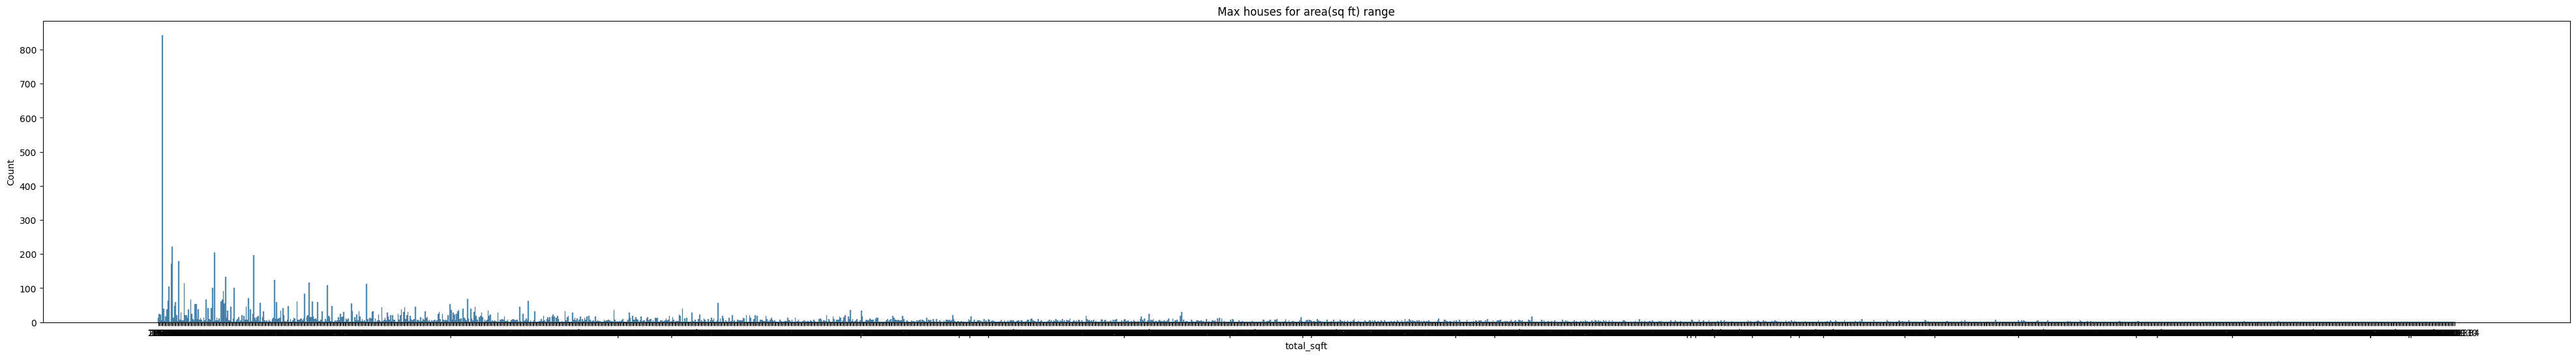

In [12]:
def sqft_plot():
    plt.figure(figsize=(50,6))
    sns.histplot(x=df.total_sqft, binwidth=5000)
    plt.title('Max houses for area(sq ft) range')

sqft_plot()

The total area in sq ft is also highly skewed we will have to clean it.
We also saw from the unique values that all values in this column weren't consistent, so will have to change that as well.

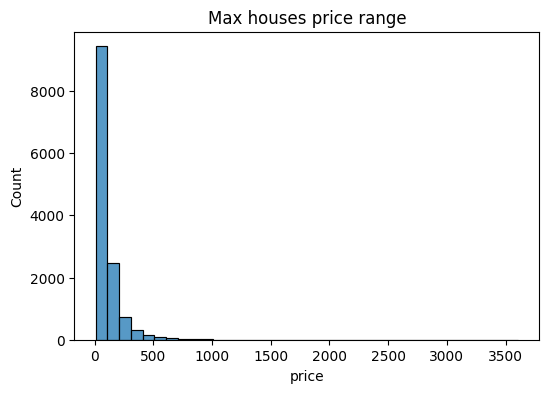

In [13]:
def price_plot():
    plt.figure(figsize=(6,4))
    sns.histplot(x=df.price, binwidth=100)
    plt.title('Max houses price range')

price_plot()

We can see that the price data is highly skewed, so we will have to remove the skewedness.

## Data Cleaning

Making a copy of our datframe to work on it

In [14]:
copy_df = df[['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 
              'balcony', 'price']].copy()

To clean our data we have:
- Removed the words bedroom, bhk and rk from the size column as we saw from above that we need to do that and then created chart for better understanding of the values now.
- Removed the null values in the data using mean, median, or a particular value, based on initial analysis.
- Some values in the total_sqft column are in the form of x-y so to use those columns I have found the mean of these values x+y/2 and replaced the x-y with this mean.
- Certain values in the total_sqft column are not in sqft so to make that an easy transition I have made a dictionary containing some of the metrics
- After the data dictionary has been formed we create a function to extract the numeric values from our dataframe copy_df.
- Using the functions created we change all the values to sqft 
- Converting the total area in sqft given as str to numeric format
- Removed skewdness of the data 

Combining the above under one function only so as to be able to use the function for preprocessing the test file as well

In [15]:
copy_df = preprocess_data(copy_df)

In [16]:
copy_df.isnull().sum()

area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

Checking the size plot after removing words like bhk, rk and bedrooms

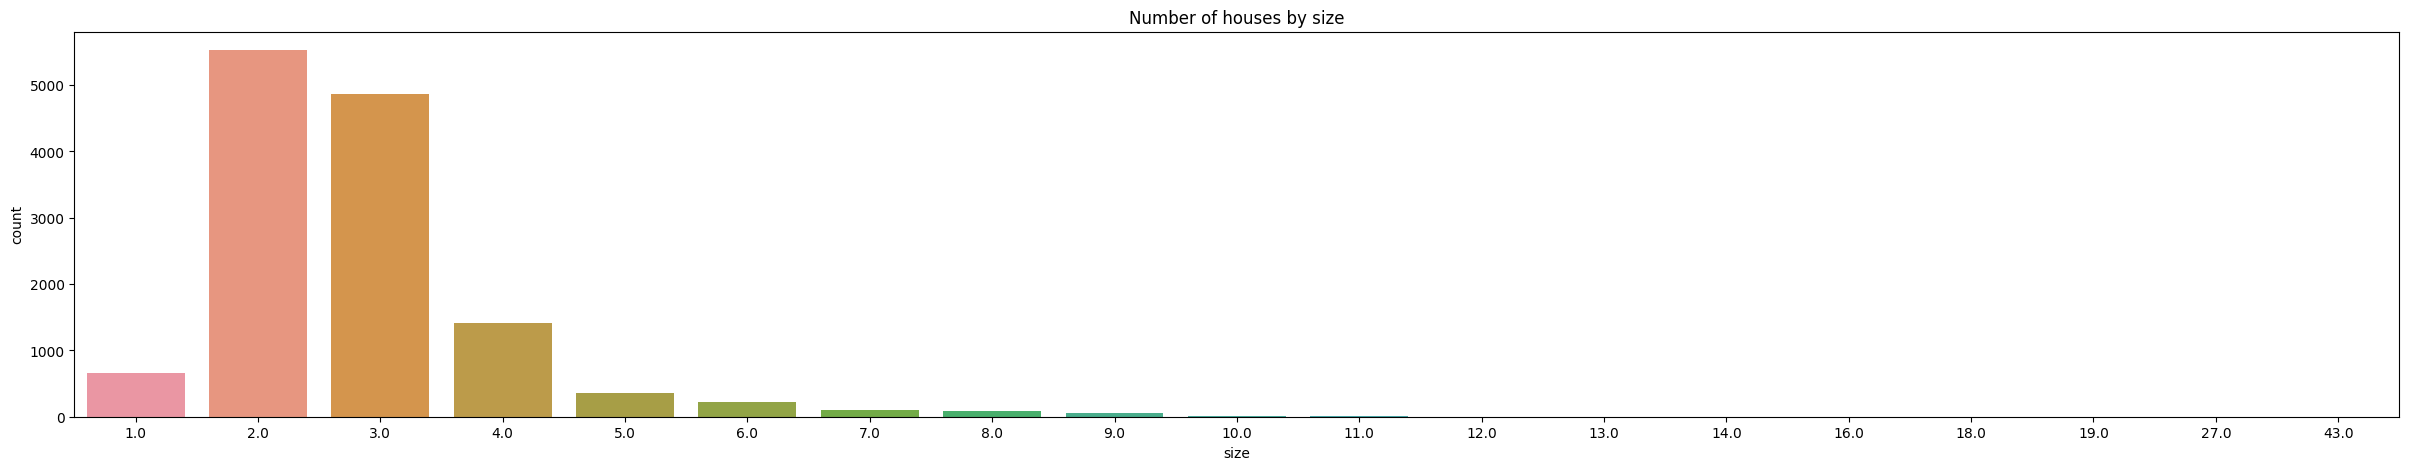

In [17]:
size_plot(copy_df, 'size')

Checking the price plot after the removed skewness

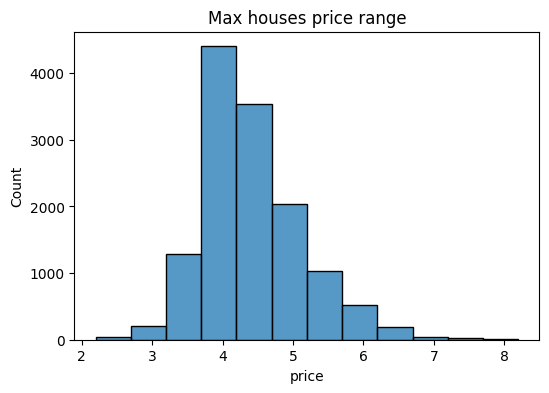

In [18]:
def price_plot():
    plt.figure(figsize=(6,4))
    sns.histplot(x=copy_df.price, binwidth=0.5)
    plt.title('Max houses price range')

price_plot()

## Feature Engineering

- Making a new column month, this column will contain only the months and not the exact date as from graphs plotted we could see that we do not need the data along with the dates
- Making a new column ready, this column will contain only the values like ready to move and immediate possession and nothing else as from graphs plotted we could see that we do not need the data along with the too many dates
- Combining the two columns month and ready we finally get the column that was desired and we can now plot our graphs based on these columns 

In [19]:
copy_df = feature_engg(copy_df)

Creating a new column address in the copy_df dataframe to map our locations to their longitude and latitudes for geo spatial analysis

In [20]:
copy_df['address'] = copy_df['location']+',Bangalore,Karnataka,India'

## Creating Plots with Target Variable(Price)

These plots will help determine which variable affects our target variable the most, so that we can move forward with that data.

Boxplot for area type and price dependency

Text(0.5, 1.0, 'Area Type vs Price')

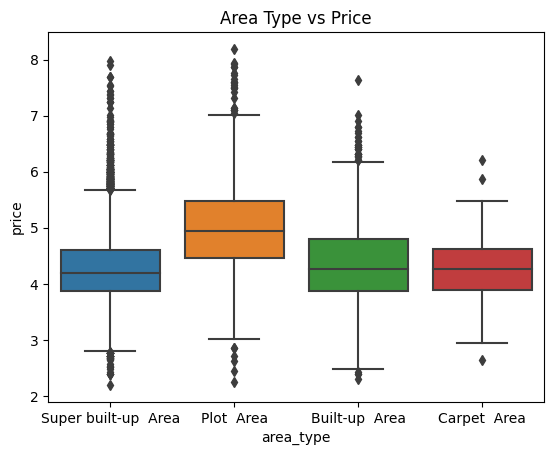

In [21]:
sns.boxplot(x = copy_df['area_type'], y=copy_df['price'])
plt.title('Area Type vs Price')

Bocplot for availability and price dependency

Text(0.5, 1.0, 'Availability vs Price')

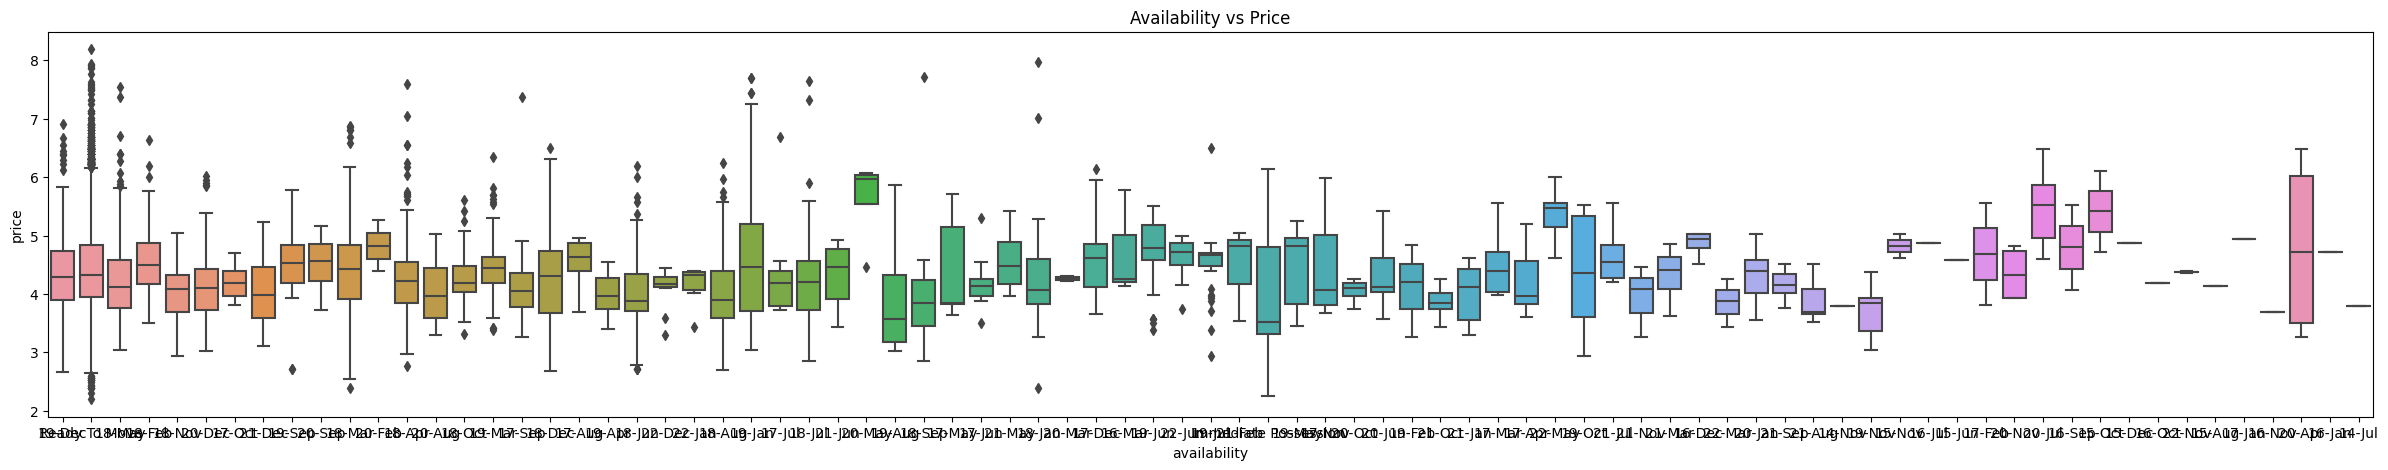

In [22]:
plt.figure(figsize=(30,5))
sns.boxplot(x = copy_df['availability'], y=copy_df['price'])
plt.title('Availability vs Price')

We can see that this data can be divided into months and then checked with the target variable, otherwise the results of the graph are not clear.

Text(0.5, 1.0, 'Availability vs Price')

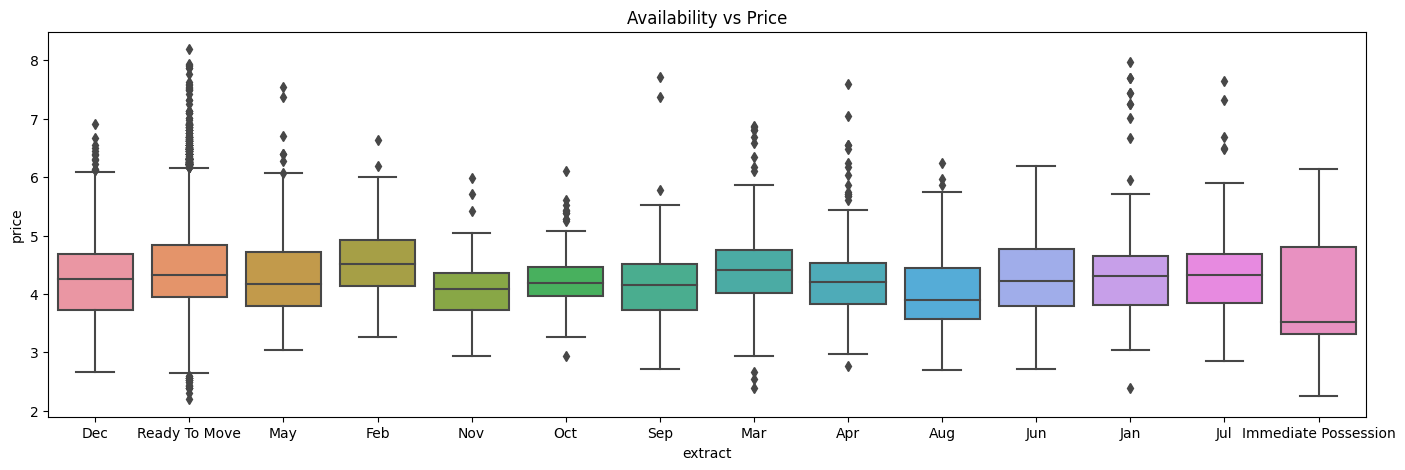

In [23]:
plt.figure(figsize=(17,5))
sns.boxplot(x = copy_df['extract'], y=copy_df['price'])
plt.title('Availability vs Price')

Text(0.5, 1.0, 'Availability on the basis of months vs Price')

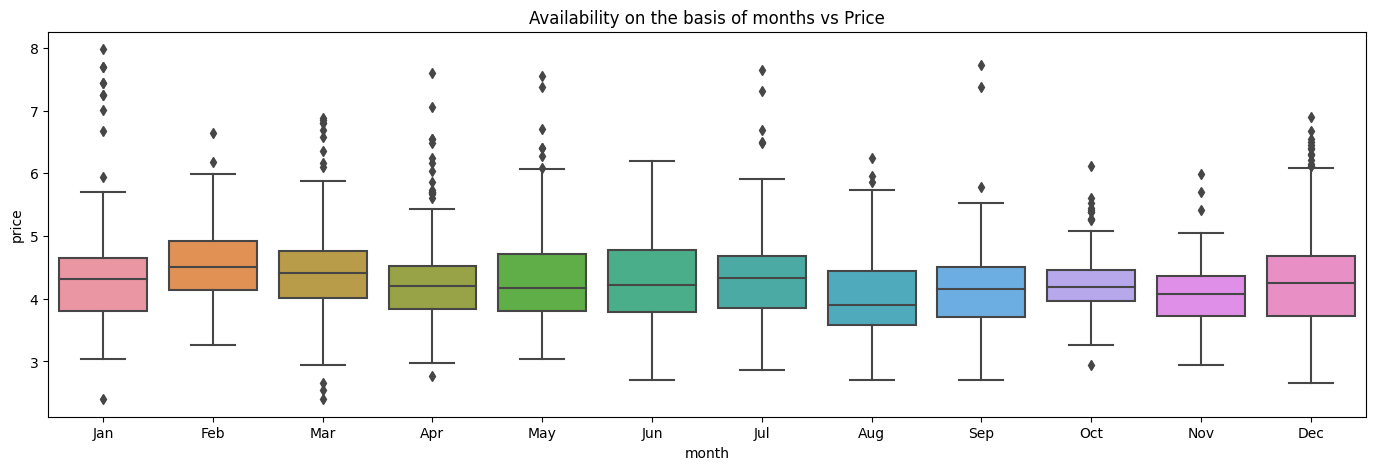

In [24]:
plt.figure(figsize=(17,5))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec']
sns.boxplot(x = copy_df['month'], y=copy_df['price'], order= month_order)
plt.title('Availability on the basis of months vs Price')

Text(0.5, 1.0, 'Availability on the basis on readiness vs Price')

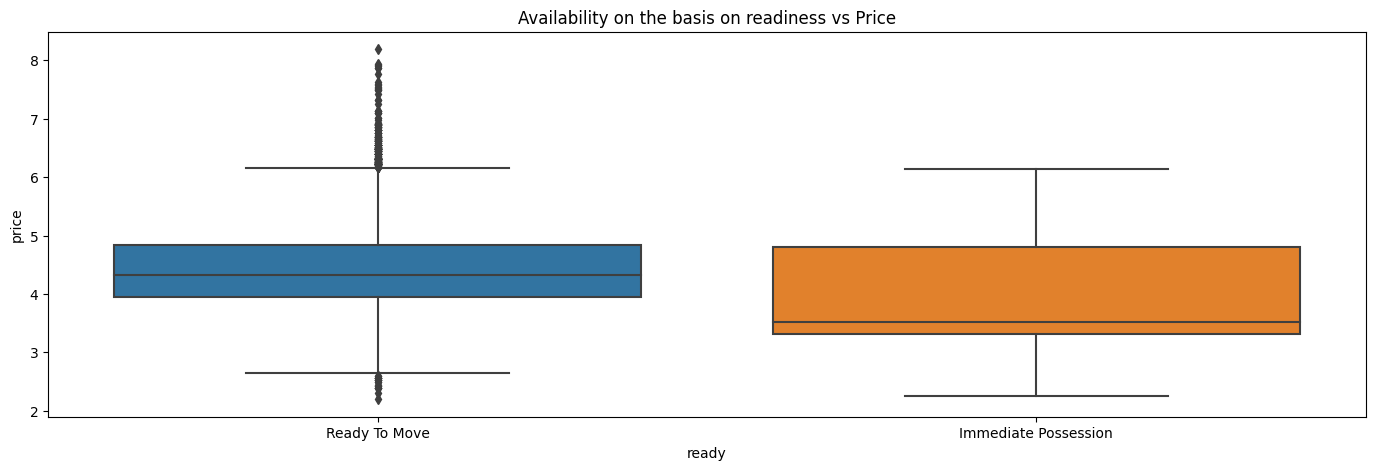

In [25]:
plt.figure(figsize=(17,5))
sns.boxplot(x = copy_df['ready'], y=copy_df['price'])
plt.title('Availability on the basis on readiness vs Price')

Boxplot for size and price dependency

Text(0.5, 1.0, 'Size vs Price')

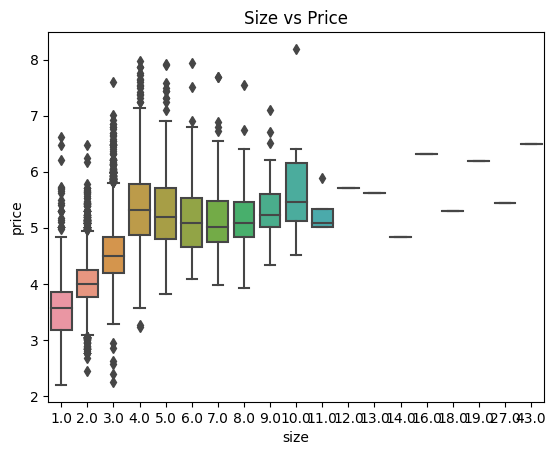

In [26]:
sns.boxplot(x = copy_df['size'], y=copy_df['price'])
plt.title('Size vs Price')

Boxplot for location and price dependency 

Text(0.5, 1.0, 'Location vs Price')

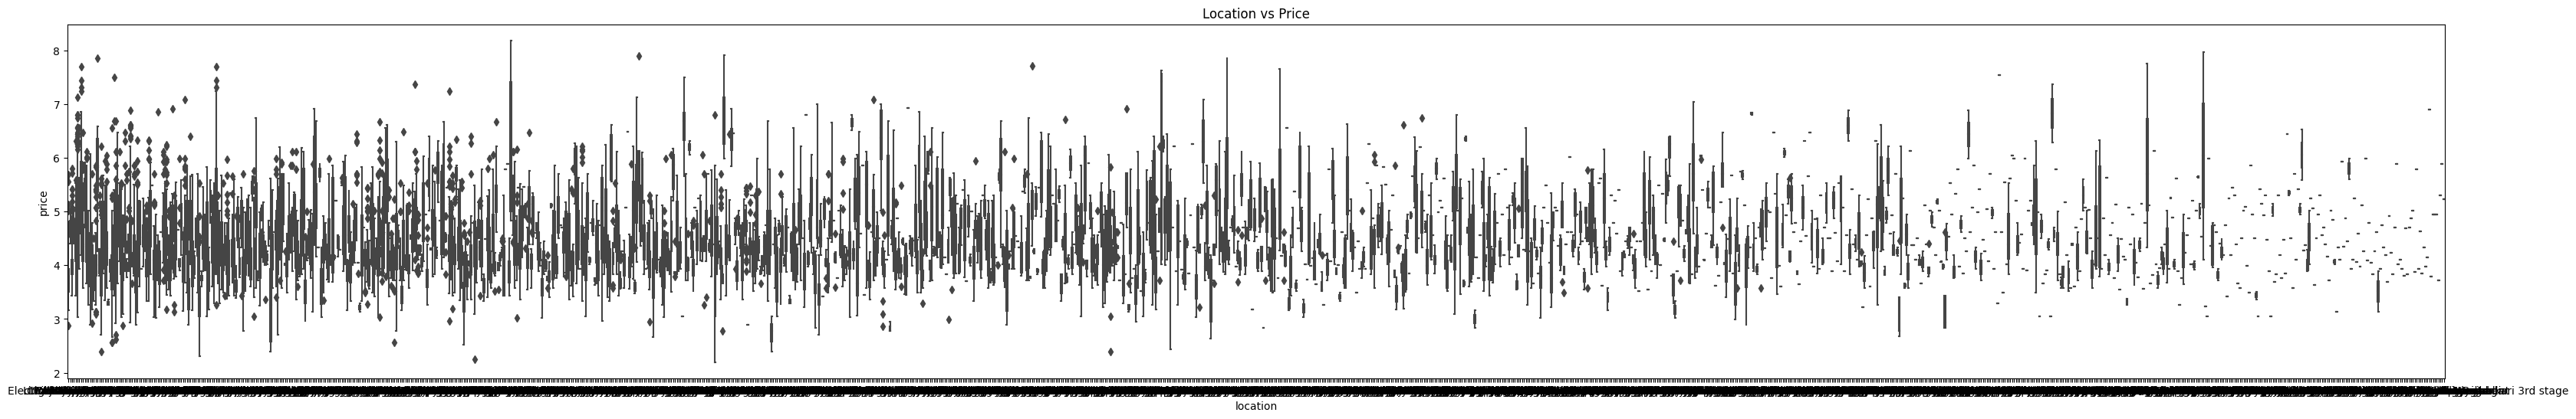

In [27]:
plt.figure(figsize=(40,6))
sns.boxplot(x = copy_df['location'], y=copy_df['price'])
plt.title('Location vs Price')

Scatterplot for total area in square ft and price dependency

Text(0.5, 1.0, 'Total area in sqft vs Price')

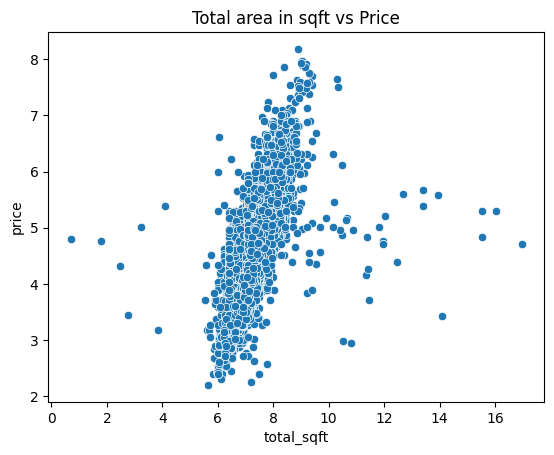

In [28]:
sns.scatterplot(x = copy_df['total_sqft'], y=copy_df['price'])
plt.title('Total area in sqft vs Price')

Boxplot for bath and price dependency 

Text(0.5, 1.0, 'Bath vs Price')

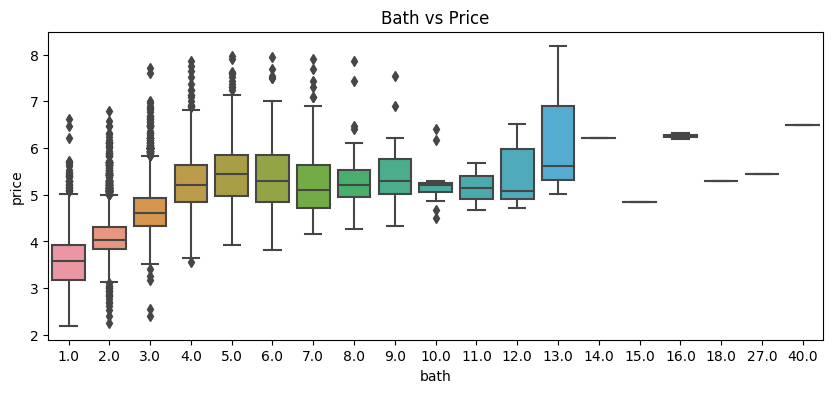

In [29]:
plt.figure(figsize=(10,4))
sns.boxplot(x = copy_df['bath'], y=copy_df['price'])
plt.title('Bath vs Price')

Boxplot for balcony and price dependency 

Text(0.5, 1.0, 'Balcony vs Price')

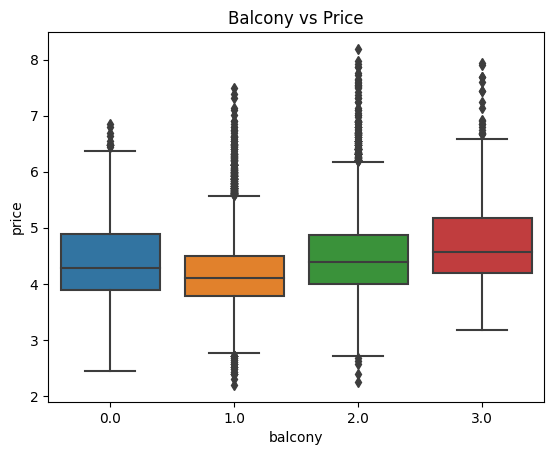

In [30]:
sns.boxplot(x = copy_df['balcony'], y=copy_df['price'])
plt.title('Balcony vs Price')

Checking correlation between bath, balcony and total area to see if any of these is highly correlated and has to ignored.

<Axes: >

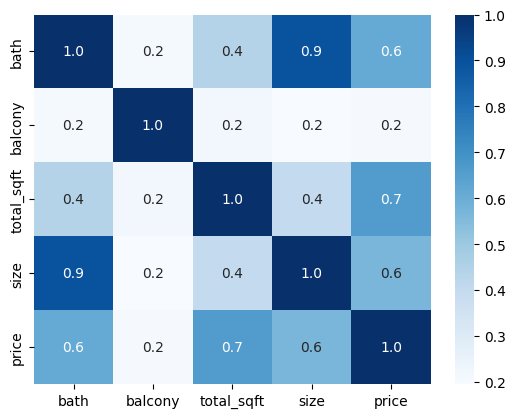

In [31]:
corr_df = copy_df[['bath', 'balcony', 'total_sqft','size', 'price']]
correlation_matrix = corr_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.1f')


We see that size and bath are highly correlated and hence one of these based on their correlation with our target variable price can be dropped.

Extracting our cleaned data to a file to start modelling on it.

In [32]:
file_path = r'D:\source\repos\OrionDataAnalyticsInternshipJul23-Proj2\data\processed/'
file_name = "cleaned.csv"
extract_info = file_path + file_name
copy_df.to_csv(extract_info, index=False)

## Geo Spatial Analysis

Extracting a new file from copy_df to use for geoencoding

In [33]:
address_df = copy_df['address'].drop_duplicates()
file_path = r'D:\source\repos\OrionDataAnalyticsInternshipJul23-Proj2\data\raw/'
file_name = "address.csv"
extract_info = file_path + file_name
address_df.to_csv(extract_info, index=False)

### Data Ingestion: the shapefile to display the map of Bangalore

In [34]:
bangaloremap = gpd.read_file(r'data\raw\bbmpwards\bbmpwards.shp')

####  Plotting complete Bangalore map using the shapefile

<Axes: >

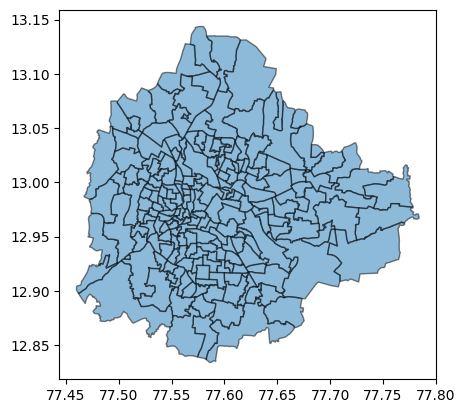

In [35]:
bangaloremap.plot(alpha=0.5, edgecolor='k', legend=True)

### Data Ingestion: the encoded address file

In [36]:
encoded_df = pd.read_csv(r"data\final\encoded_addr.csv")

Reformatting our data into a GeoPandas Dataframe because we cannot use it directly as a dataframe

In [37]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(encoded_df['longitude'], encoded_df['latitude'])]
geo_df = gpd.GeoDataFrame(encoded_df, crs = crs, geometry = geometry)

d:\source\repos\OrionDataAnalyticsInternshipJul23-Proj2\Orion2.venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Plotting our encoded data using subplots on the bangalore map to see if we can come to any conclusion using it

(77.45, 77.8)

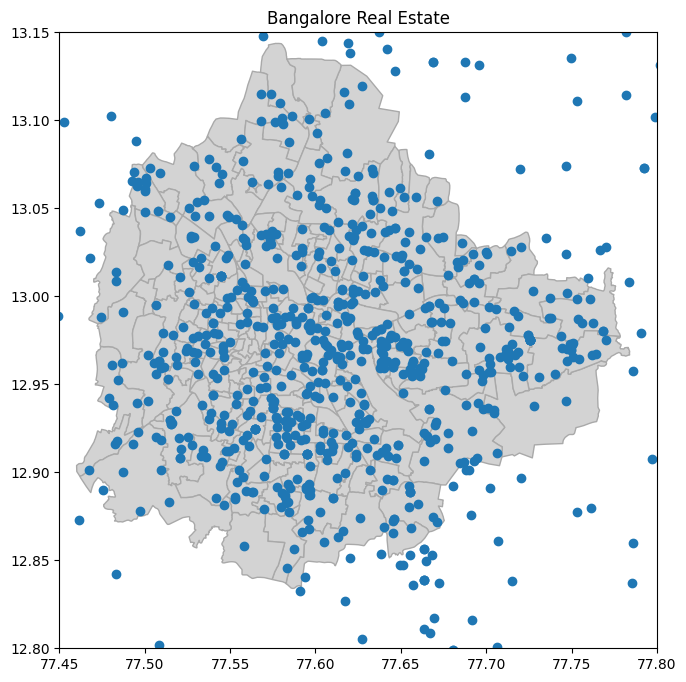

In [38]:
fig, ax = plt.subplots(figsize = (8,8))
bangaloremap.plot(ax=ax, color='lightgrey',edgecolor='Darkgrey')
geo_df.plot(ax=ax)

ax.set_title('Bangalore Real Estate')
ax.set_ylim(12.8, 13.15)
ax.set_xlim(77.45,77.8)

Reducing alpha to see where the houses are concentrated, as with all the dots with same intensity it is becoming difficult to do the same.

(77.45, 77.8)

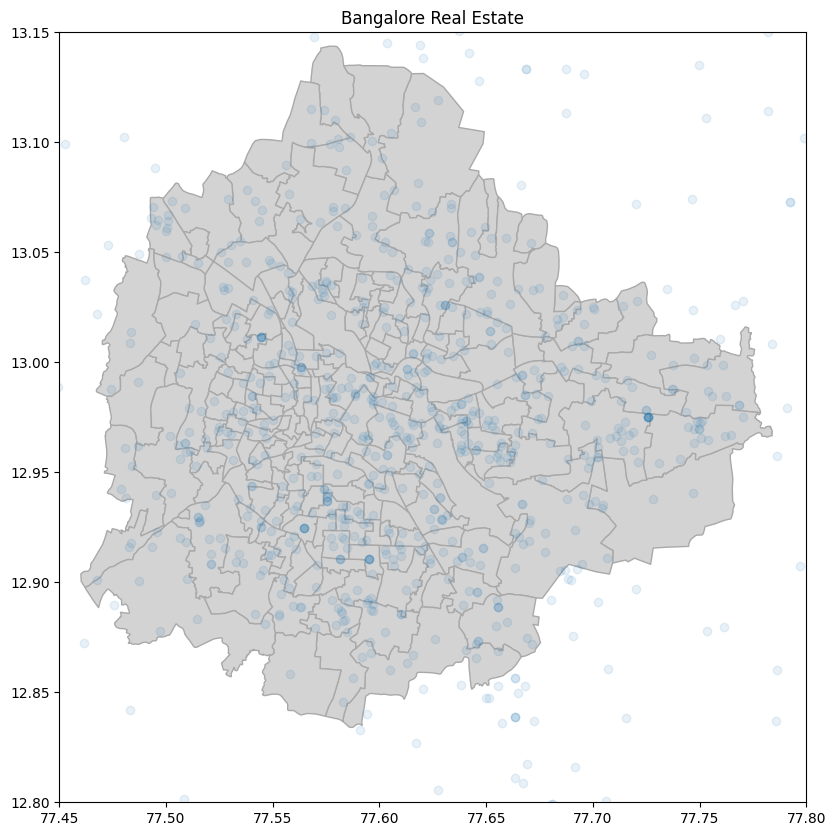

In [39]:
fig, ax = plt.subplots(figsize = (10,10))
bangaloremap.to_crs(epsg=4326).plot(ax=ax, color='lightgrey',edgecolor='Darkgrey')
geo_df.plot(ax=ax, alpha = .1 )
ax.set_title('Bangalore Real Estate')
ax.set_ylim(12.8, 13.15)
ax.set_xlim(77.45,77.8)
# plt.savefig('Property Map')

Using heatmap to check where the houses with the max price are located, as colours in the heatmap will indicate price range.

(77.45, 77.8)

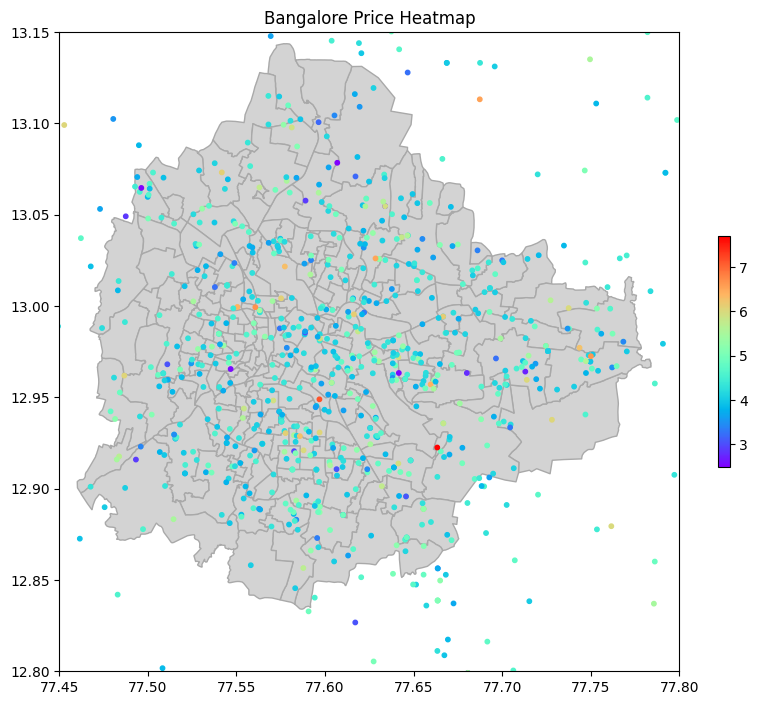

In [40]:
geo_df['price'] = copy_df['price']
fig, ax = plt.subplots(figsize = (10,10))
bangaloremap.to_crs(epsg=4326).plot(ax=ax, color='lightgrey',edgecolor='Darkgrey')
geo_df.plot(column = 'price', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Bangalore Price Heatmap')
ax.set_ylim(12.80, 13.15)
ax.set_xlim(77.45,77.8)

Using heatmap to check where the houses with the max area are located, as colours in the heatmap will indicate area range.

(77.45, 77.8)

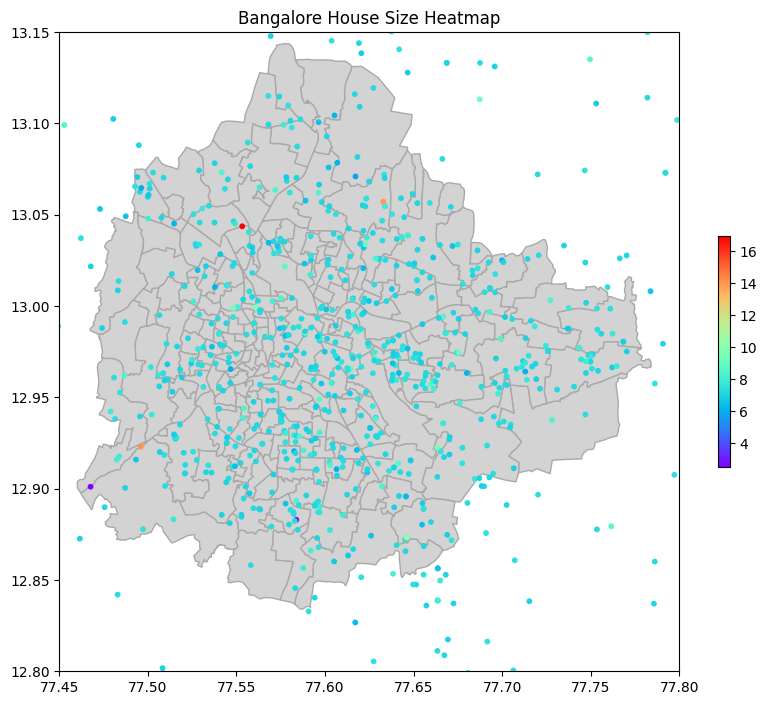

In [41]:
geo_df['price'] = (copy_df['total_sqft'])
fig, ax = plt.subplots(figsize = (10,10))
bangaloremap.to_crs(epsg=4326).plot(ax=ax, color='lightgrey',edgecolor='Darkgrey')
geo_df.plot(column = 'price', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Bangalore House Size Heatmap')
ax.set_ylim(12.80, 13.15)
ax.set_xlim(77.45,77.8)

- We can see from geo spatial analysis that there is not particular area in the data that has a concentration of houses, nor an area where house price or house area is always higher. 
- We can also see that there are many outliers in the data, or it could also suggest that our shapefile is not up to date, or our coordinates are not accurate.
- Our data suggests that the location in bangalore doesn't have an affect on price and we do not need it to be able to effectively train our model.

Using a correlation matrix to verify the above analysis

<Axes: >

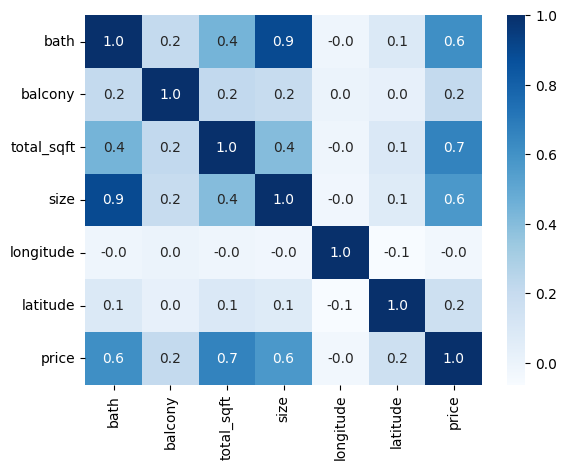

In [42]:
geo_df.drop('price',axis=1,inplace = True)
new_df = pd.merge(copy_df,geo_df, on='address')

corr_df = new_df[['bath', 'balcony', 'total_sqft','size','longitude','latitude', 'price']]
correlation_matrix = corr_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.1f')

The correlation matrix proves that our analysis that the locations are not correlated with our target variable and do not need to be used during training our model.